In [24]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [25]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# Physics
b_max = 0.3  # maximum ice balance m/yr
grad_b = 0.001  # gradient of ice balance as a function of elevation. yr^-1

z_ELA = 1200  # equilibrium line altitude
Lx = 1e5  # model length, m
ttot = 3e3  # total time
rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
kD = fd * rhog**3  # lump all constants for diffusivity together

# Numerics
nx = 201  # number of cells
dx = Lx / (nx - 1)  # number of cells 
dtmax = 1      # initial dt, will be changed within loop, yr
dt    = dtmax  # initial dt, will be changed within loop, yr
x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
nout = 500  # frequency of plotting

# Initialization
Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography
H = torch.zeros(nx, device=device)  # ice thickness
time = 0.0  # initialize time
nplot = 0  # counter for plotting

Z = Z_bed + H  # ice surface

time = 0
it = 0
# Epsilon to avoid division by zero
epsilon = 1e-12

In [42]:
# Visualization function using tolist()
def visualize_glacier(x, Z, Z_bed, z_ELA, b, time):
    Z_list = Z.cpu().tolist()  # Convert to list
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    b_list = b.cpu().tolist()  # Convert to list
    clear_output(wait=True)  # Clear the previous output in the notebook
    
    plt.figure(2, figsize=(7, 5), dpi=200)
    plt.subplot(2, 2, 1)
    plt.plot([xi / 1000 for xi in x_list], Z_list, 'b', linewidth=2) 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA, z_ELA], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier après ' + str(int(time)) + ' années')

    plt.subplot(2, 2, 2)
    plt.plot([min(grad_b * (zi - z_ELA), b_max) for zi in Z_list], Z_list, '--k', linewidth=2)
    plt.plot([min(b_list), b_max + 0.3], [z_ELA, z_ELA], 'g')
    plt.plot([0, 0], [min(Z_bed_list), max(Z_bed_list)], 'k', linewidth=1)
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.title('Fonction bilan de masse') 
    plt.xlabel('Bilan de masse, m/a')  

    plt.subplot(2, 2, 3, aspect=20.0)
    plt.plot([xi / 1000 for xi in x_list], b_list, 'b', linewidth=2)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [0, 0], 'k', linewidth=1)
    plt.title('Bilan de masse effectif')
    plt.xlabel('Distance, km') 
    plt.ylabel('Bilan de masse, m/a') 

    plt.show()

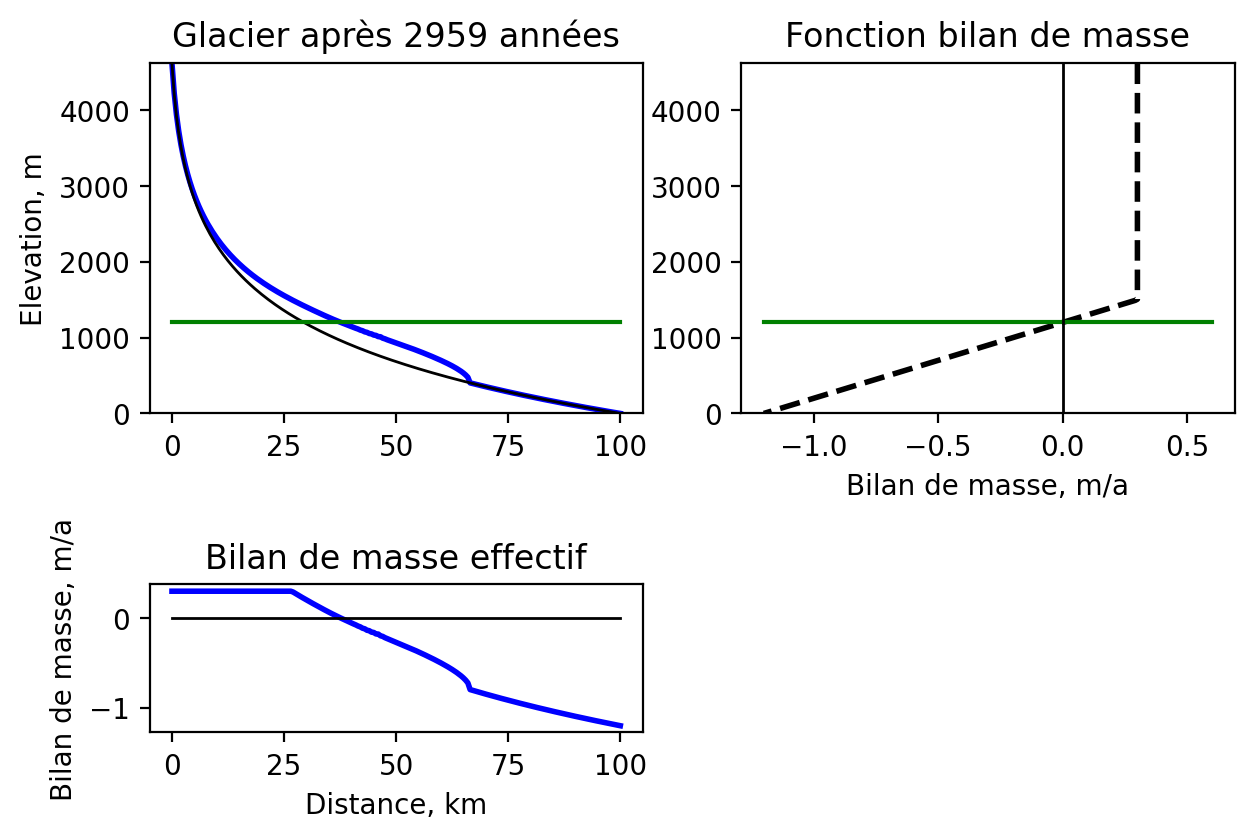

In [34]:
# Time loop
while time < ttot:

    # compute dHdt due to diffusion
    H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
    D = kD * H_av**5 * (torch.diff(Z) / dx)**2  # diffusivity (nx-1)
    qx = -D * torch.diff(Z) / dx  # ice flux
    dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow

    # update time step as function of D
    max_D = torch.max(D).item()
    dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step (added epsilon to avoid division by zero)

    # update thickness of ice (iceflow)
    H[1:-1] += dt * dHdt  # update ice thickness from flow

    # update ice thickness (mass balance)
    b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
    H[1:-1] += dt * b[1:-1] 

    H[H < 0] = 0  # set any negative thickness to 0

    # Boundary conditions
    H[0] = 0
    H[-1] = 0

    Z = Z_bed + H  # update ice surface
    time += dt  # update time

    it += 1

    # Call visualization function
    if it % nout == 0:
        visualize_glacier(x, Z, Z_bed, z_ELA, b, time)

In [35]:
# Sav e the observations.
# torch.save(H,'observed_thk.pt')

In [57]:
# Function to perform forward simulation of glacier thickness
def forward_simulation(b_max, grad_b, z_ELA, nx=201, Lx=1e5, ttot=3e3, dtmax=1, device='cpu'):
    # # Physics constants
    # rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
    # fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
    # kD = fd * rhog**3  # lump all constants for diffusivity together
    # dx = Lx / (nx - 1)  # cell size
    it=0
    # Initialization
    x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
    Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography
    H = torch.zeros(nx, device=device)  # initial ice thickness
    Z = Z_bed + H  # ice surface
    
    time = 0.0
    epsilon = 1e-12  # small constant to avoid division by zero

    while time < ttot:
    # compute dHdt due to diffusion
        H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
        D = kD * H_av**5 * (torch.diff(Z) / dx)**2  # diffusivity (nx-1)
        qx = -D * torch.diff(Z) / dx  # ice flux
        dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow

        # update time step as function of D
        max_D = torch.max(D).item()
        dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step (added epsilon to avoid division by zero)

        # update thickness of ice (iceflow)
        H[1:-1] += dt * dHdt  # update ice thickness from flow

        # update ice thickness (mass balance)
        b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
        H[1:-1] += dt * b[1:-1] 

        H[H < 0] = 0  # set any negative thickness to 0

        # Boundary conditions
        H[0] = 0
        H[-1] = 0

        Z = Z_bed + H  # update ice surface
        time += dt  # update time

        it += 1
        # # Call visualization function
        # if it % nout == 0:
        #     visualize_glacier(x, Z, Z_bed, z_ELA, b, time)
    return H

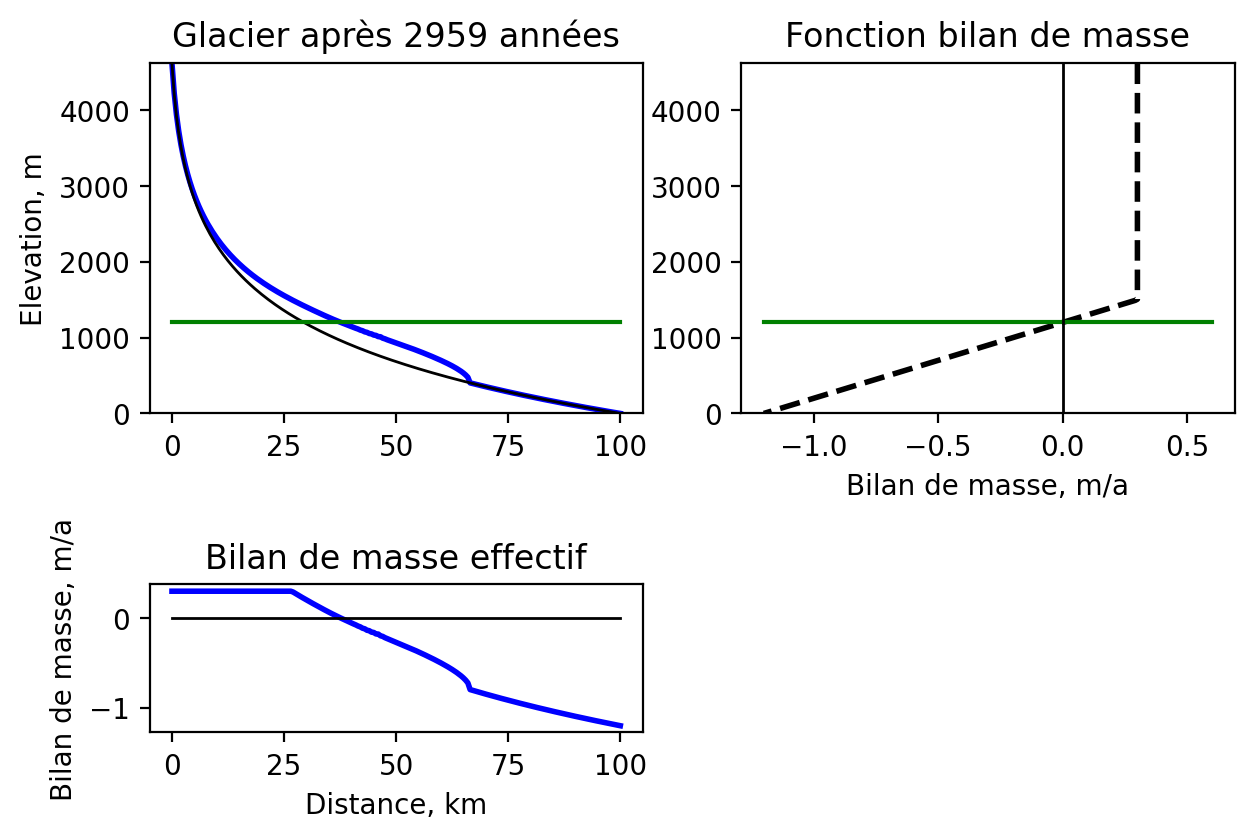

tensor([  0.0000,  13.5196,  19.4441,  24.5830,  29.3656,  33.9308,  38.3388,
         42.6302,  46.8251,  50.9420,  54.9928,  58.9874,  62.9318,  66.8339,
         70.6986,  74.5294,  78.3304,  82.1056,  85.8580,  89.5896,  93.3024,
         97.0001, 100.6832, 104.3546, 108.0150, 111.6649, 115.3088, 118.9423,
        122.5710, 126.1912, 129.8055, 133.4130, 137.0111, 140.6011, 144.1784,
        147.7442, 151.2930, 154.8263, 158.3375, 161.8248, 165.2859, 168.7145,
        172.1077, 175.4612, 178.7705, 182.0320, 185.2385, 188.3868, 191.4719,
        194.4874, 197.4279, 200.2887, 203.0632, 205.7446, 208.3288, 210.8119,
        213.1934, 215.4742, 217.6510, 219.7303, 221.7020, 223.5858, 225.3497,
        227.0581, 228.5965, 230.1783, 231.4334, 232.9846, 233.8247, 235.5215,
        235.7166, 237.8087, 237.1669, 239.8283, 238.4587, 241.5074, 239.8622,
        242.7485, 241.3603, 243.5767, 242.8144, 244.2802, 244.1940, 245.1919,
        245.5606, 246.3786, 246.9272, 247.6887, 248.1153, 248.86

In [54]:
# test the forward run 
forward_simulation(b_max,grad_b,z_ELA)

In [59]:
# Initial guesses for inversion problem
b_max = torch.tensor(0.1, requires_grad=True, device='cpu')
grad_b = torch.tensor(0.005, requires_grad=True, device='cpu')
z_ELA = torch.tensor(1000.0, requires_grad=True, device='cpu')

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('observed_thk.pt', weights_only=True).to('cpu') # Ensure it's on the right device

# Optimizer setup
optimizer = torch.optim.Adam([b_max, grad_b, z_ELA], lr=10)

# Regularization weight (tune this value)
reg_lambda = 0.1

# Optimization loop
n_iterations = 5



# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []

for i in range(n_iterations):
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated = forward_simulation(b_max, grad_b, z_ELA)
    
    # Compute data fidelity and regularization
    data_fidelity = torch.mean((H_simulated - observed_thk) ** 2)
    smoothness_reg = torch.sum((H_simulated[1:] - H_simulated[:-1]) ** 2)
    
    # Compute total loss
    loss = data_fidelity + reg_lambda * smoothness_reg
    
    # Backpropagate loss and update parameters
    loss.backward()
    optimizer.step()
    
    # Store loss components for plotting later
    total_loss_history.append(loss.item())
    data_fidelity_history.append(data_fidelity.item())
    regularization_history.append((reg_lambda * smoothness_reg).item())
    
    # Print loss and current parameters every 50 iterations
    if (i + 1) % 1 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Loss: {loss.item()}")
        print(f"b_max: {b_max.item()}, grad_b: {grad_b.item()}, z_ELA: {z_ELA.item()}")


/tmp/ipykernel_13221/2704964296.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  observed_thk = torch.load('observed_thk.pt').to('cpu')  # Ensure it's on the right device

Iteration 1/50, Loss: 8399.5771484375
b_max: 0.10000000149011612, grad_b: nan, z_ELA: nan
Iteration 2/50, Loss: nan
b_max: 0.10000000149011612, grad_b: nan, z_ELA: nan
Iteration 3/50, Loss: nan
b_max: 0.10000000149011612, grad_b: nan, z_ELA: nan
Iteration 4/50, Loss: nan
b_max: 0.10000000149011612, grad_b: nan, z_ELA: nan
Iteration 5/50, Loss: nan
b_max: 0.10000000149011612, grad_b: nan, z_ELA: nan


KeyboardInterrupt: 

In [ ]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# After the optimization loop
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)
